# The problem

"Pile up" of updates propagating to matplotlib:

https://www.youtube.com/watch?v=NFrVjdiAiOk&feature=youtu.be

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

x = np.linspace(0,1,100)

def update_plot(p=1):
    plt.plot(x, x**p)
        
interact(update_plot, p=(0,1,0.01))

interactive(children=(FloatSlider(value=1.0, description='p', max=1.0, step=0.01), Output()), _dom_classes=('w…

<function __main__.update_plot(p=1)>

Discussed here:

https://github.com/jupyter-widgets/ipywidgets/issues/663

Solutions:

* Turn off continuous update
* A hand-build debouncer/throttler: https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Events.html#Debouncing


# Option: turn off continuous update

This helps of course, but is much less "interactive". It also needs a bit more boilerplate and you have to specify for each individual widget that you want continuous update off. 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

x = np.linspace(0,1,100)

def update_plot(p=1):
    plt.plot(x, x**p)
        
interact(update_plot, p=widgets.FloatSlider(min=0,max=1,step=0.01,continuous_update = False))

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='p', max=1.0, step=0.01), Ou…

<function __main__.update_plot(p=1)>

# Throttler

Based on:

https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Events.html#Throttling

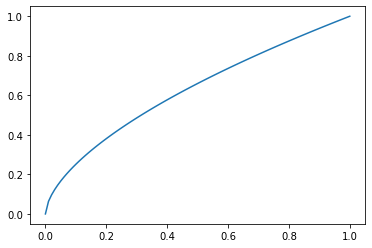

interactive(children=(FloatSlider(value=0.0, description='p', max=1.0, step=0.01), Output()), _dom_classes=('w…

<function __main__.throttle.<locals>.decorator.<locals>.throttled(*args, **kwargs)>

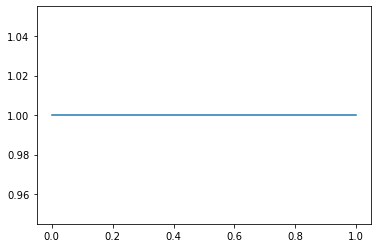

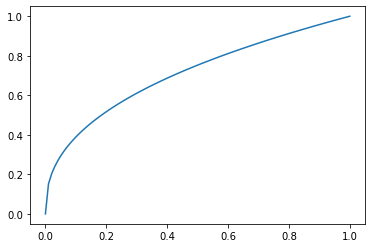

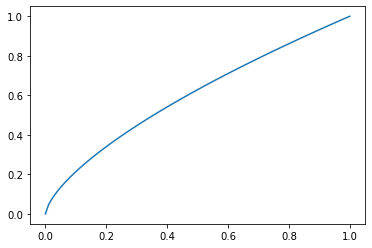

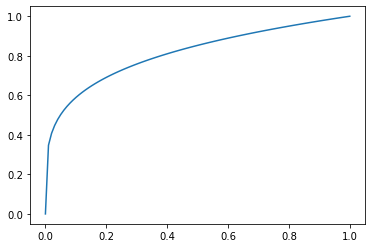

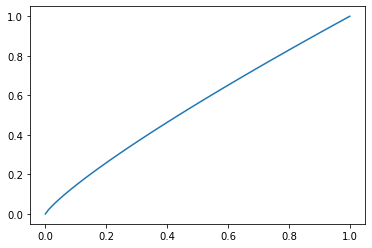

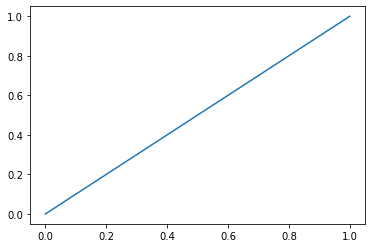

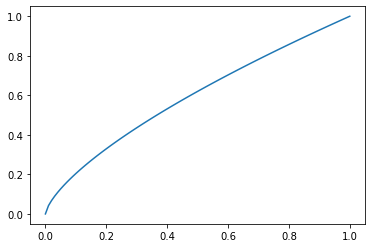

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

import asyncio
from time import time

class Timer:
    def __init__(self, timeout, callback):
        self._timeout = timeout
        self._callback = callback

    async def _job(self):
        await asyncio.sleep(self._timeout)
        self._callback()

    def start(self):
        self._task = asyncio.ensure_future(self._job())

    def cancel(self):
        self._task.cancel()
        
def throttle(wait):
    """ Decorator that prevents a function from being called
        more than once every wait period. """
    def decorator(fn):
        time_of_last_call = 0
        scheduled, timer = False, None
        new_args, new_kwargs = None, None
        def throttled(*args, **kwargs):
            nonlocal new_args, new_kwargs, time_of_last_call, scheduled, timer
            def call_it():
                nonlocal new_args, new_kwargs, time_of_last_call, scheduled, timer
                time_of_last_call = time()
                fn(*new_args, **new_kwargs)
                scheduled = False
            time_since_last_call = time() - time_of_last_call
            new_args, new_kwargs = args, kwargs
            if not scheduled:
                scheduled = True
                new_wait = max(0, wait - time_since_last_call)
                timer = Timer(new_wait, call_it)
                timer.start()
        return throttled
    return decorator

@throttle(0.2)
def update_plot(p=1):
    plt.plot(x, x**p)

interact(update_plot, p=(0,1,0.01))

OK, that did not work. Let's try it with a interactive_output object, I suspect that might be the problem.

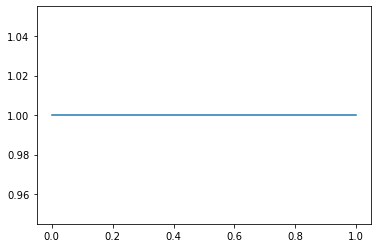

Output()

FloatSlider(value=0.0, max=1.0, step=0.01)

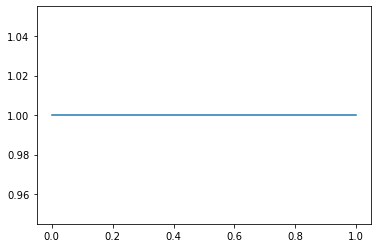

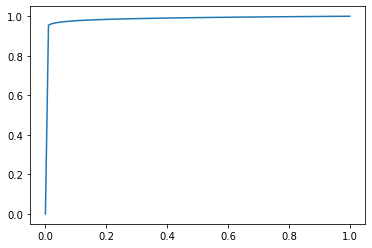

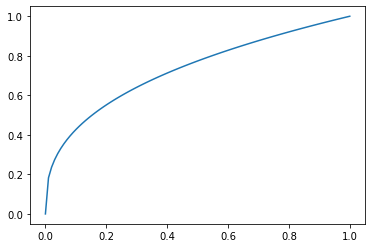

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets 

import asyncio
from time import time

class Timer:
    def __init__(self, timeout, callback):
        self._timeout = timeout
        self._callback = callback

    async def _job(self):
        await asyncio.sleep(self._timeout)
        self._callback()

    def start(self):
        self._task = asyncio.ensure_future(self._job())

    def cancel(self):
        self._task.cancel()
        
def throttle(wait):
    """ Decorator that prevents a function from being called
        more than once every wait period. """
    def decorator(fn):
        time_of_last_call = 0
        scheduled, timer = False, None
        new_args, new_kwargs = None, None
        def throttled(*args, **kwargs):
            nonlocal new_args, new_kwargs, time_of_last_call, scheduled, timer
            def call_it():
                nonlocal new_args, new_kwargs, time_of_last_call, scheduled, timer
                time_of_last_call = time()
                fn(*new_args, **new_kwargs)
                scheduled = False
            time_since_last_call = time() - time_of_last_call
            new_args, new_kwargs = args, kwargs
            if not scheduled:
                scheduled = True
                new_wait = max(0, wait - time_since_last_call)
                timer = Timer(new_wait, call_it)
                timer.start()
        return throttled
    return decorator

@throttle(0.1)
def update_plot(p=1):
    plt.plot(x, x**p)
    
p = widgets.FloatSlider(min=0,max=1,step=0.01)

out = widgets.interactive_output(update_plot, {"p": p})
display(out, p)

Nope, not solved. Let's try something else. 

interactive(children=(FloatSlider(value=1.0, description='p', max=1.0, step=0.01), Output()), _dom_classes=('w…

<function __main__.update_plot(p=1)>

here


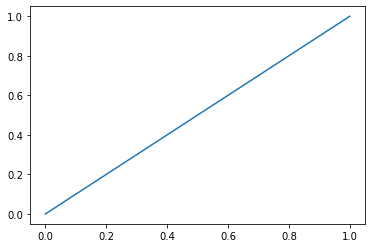

here


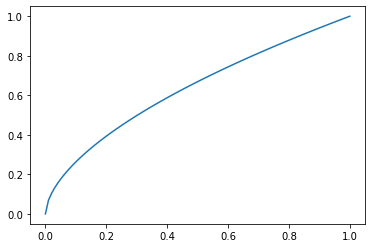

here


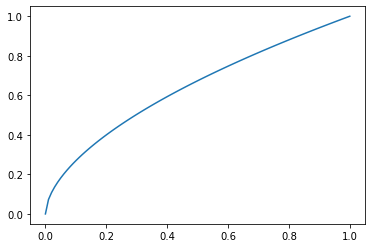

here


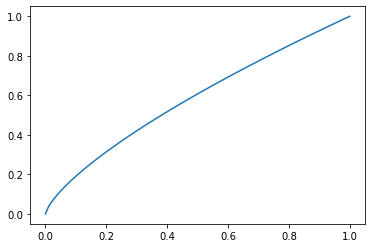

here


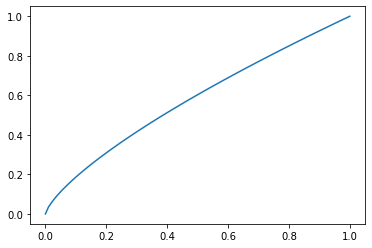

here


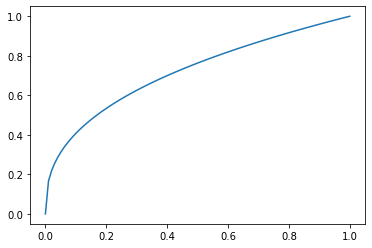

here


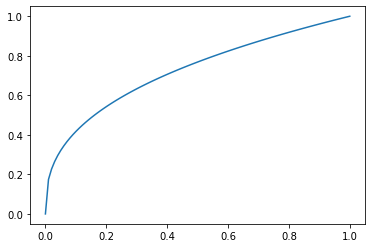

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

import asyncio
from time import time

class Timer:
    def __init__(self, timeout, callback):
        self._timeout = timeout
        self._callback = callback

    async def _job(self):
        await asyncio.sleep(self._timeout)
        self._callback()

    def start(self):
        self._task = asyncio.ensure_future(self._job())

    def cancel(self):
        self._task.cancel()
        
def throttle(wait):
    """ Decorator that prevents a function from being called
        more than once every wait period. """
    def decorator(fn):
        time_of_last_call = 0
        scheduled, timer = False, None
        new_args, new_kwargs = None, None
        def throttled(*args, **kwargs):
            nonlocal new_args, new_kwargs, time_of_last_call, scheduled, timer
            def call_it():
                nonlocal new_args, new_kwargs, time_of_last_call, scheduled, timer
                time_of_last_call = time()
                fn(*new_args, **new_kwargs)
                scheduled = False
            time_since_last_call = time() - time_of_last_call
            new_args, new_kwargs = args, kwargs
            if not scheduled:
                scheduled = True
                new_wait = max(0, wait - time_since_last_call)
                timer = Timer(new_wait, call_it)
                timer.start()
        return throttled
    return decorator

def update_plot(p=1):
    @throttle(0.2)
    def do_plot():
        print("here")
        plt.plot(x, x**p)
        plt.show()
    do_plot()
    return None

interact(update_plot, p=(0,1,0.01))

OK, basically a big f-ing pita :)

https://github.com/jupyter-widgets/ipywidgets/issues/1919

In [38]:
import ipywidgets as widgets 
import matplotlib.pyplot as plt

out = widgets.Output(layout=widgets.Layout(height='300px'))

x = np.linspace(0,1,100)

def f(change):
    with out:
        fig, ax = plt.subplots()
        ax.plot([0, 1],[0, 10])
        ax.set_title(change['new'])
        out.clear_output()  # Required, otherwise output area stays the same but plots get added
        # display(fig)  # Doesn't work as a replacement of plt.show()
        plt.show()  # If not here, multiple plots are shown!

w = widgets.IntSlider(min=0, max=10, value=5)
w.observe(f, names="value")
display(w, out)

IntSlider(value=5, max=10)

Output(layout=Layout(height='300px'))

OK, I had a poke in the source code: 

https://github.com/jupyter-widgets/ipywidgets/blob/master/ipywidgets/widgets/interaction.py

There is a specific internal function called `show_inline_matplotlib_plots()` along with a description of problems associated with matplotlib inline and interact...


```
from ipykernel.pylab.backend_inline import flush_figures
```

seems to be the solution...?

In [41]:
from ipykernel.pylab.backend_inline import flush_figures
import ipywidgets as widgets 
import matplotlib.pyplot as plt

out = widgets.Output(layout=widgets.Layout(height='300px'))

x = np.linspace(0,1,100)

def f(change):
    with out:
        fig, ax = plt.subplots()
        ax.plot([0, 1],[0, 10])
        ax.set_title(change['new'])
        out.clear_output()
        flush_figures()

w = widgets.IntSlider(min=0, max=10, value=5)
w.observe(f, names="value")
display(w, out)

IntSlider(value=5, max=10)

Output(layout=Layout(height='300px'))

OK, that was not the directly the solution, still flashing. I will read further in the interact code. 

Looking through it, it looks like there are a large number of hacks implemented to get things to work with matplotlib inline. Probably this crazy behaviour is related to breaking some of these hacks. 

# Reproducing interact without interacting

In [61]:
import ipywidgets as widgets 
import matplotlib.pyplot as plt

#out = widgets.Output(layout=widgets.Layout(height='300px'))

x = np.linspace(0,1,100)

@throttle(0.2)
def update_plot(w):
    with out:
        # Without clear_output(), figures get appended below each other inside
        # the output widget
        # Ah ha! Got it! I need wait=True!
        out.clear_output(wait=True)
        plt.plot(x, x**p_widget.value)  
        plt.show()

out = widgets.Output()
p_widget = widgets.FloatSlider(min=0, max=2, step=0.1, value = 1)
update_plot([])
p_widget.observe(update_plot)
display(p_widget, out)

FloatSlider(value=1.0, max=2.0)

Output()